# Experiment 5.1 - Features extracted using Inception Resnet v2 + SVM 

Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/). We used a pre-trained CNN to extract features based on B-mode images. 

The CNNfeatures are extracted using the pretrained Inception-Resnet-v2 implemented in Keras.
See reference: https://jkjung-avt.github.io/keras-inceptionresnetv2/

![Screen Shot 2020-10-12 at 2 57 22 PM](https://user-images.githubusercontent.com/23482039/95781182-47437700-0c9b-11eb-8826-594811ba3322.png)







In [1]:
import sys
import random
sys.path.append('../src')
import warnings
warnings.filterwarnings("ignore") 

from utils.compute_metrics import get_metrics, get_majority_vote,log_test_metrics
from utils.split import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from tqdm import tqdm
from pprint import pprint

from itertools import product
import pickle
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt


## 1. Retrieve Extracted Features

In [2]:
with open('../data/03_features/inception_dict_tensor_avg_pooling.pickle', 'rb') as handle:
    features_dict = pickle.load(handle)
    df_features = features_dict ['features']


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. Cross Validation using SVM Classification

> Methods that exclude outliers were used to normalize the features. Patient-specific leave-one-out cross-validation (LOOCV) was applied to evaluate the classification. In each case, the test set consisted of10 images from the same patient and the training set contained 540 images from the remaining 54 patients. For each training set, fivefold cross-validation and grid search were applied to indicate the optimal SVM classifier hyperparameters and the best kernel. To address the problem of class imbalance, the SVM hyperparameter C of each class was adjusted inversely proportional to that class frequency in the training set. Label 1 indicated the image containing a fatty liver and label −1 otherwise. 


In [3]:
# Set the parameters by cross-validation
param_gamma = [1e-3, 1e-4]
param_C = [1, 10, 1000] 
svm_class_weight = [None, 'balanced']
rbf_params = list(product(['kernel'],param_gamma, param_C, svm_class_weight ))
linear_params = list(product(['linear'],param_C, svm_class_weight))
params = rbf_params + linear_params

In [4]:
def train_valid(param, X_train,X_valid,y_train, y_valid):
    if param[0] == 'kernel': 
        #The “balanced” mode uses the values of y to automatically adjust weights inversely
        #proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
        model = SVC(gamma=param[1], C=param[2], class_weight= param[3])
    if param[0] == 'linear': 
        #The “balanced” mode uses the values of y to automatically adjust weights inversely
        #proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
        model = LinearSVC(C=param[1], class_weight= param[2])

    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    acc, auc, specificity, sensitivity = get_metrics(y_valid, predictions)
    return acc, auc, specificity, sensitivity , predictions


In [5]:
def log_val_metrics(params, metrics, test_n_splits):
    mlflow.set_experiment('val_inception_avg_pooling_svm_experiment')
    # log mlflow params
    for param in params:
        with mlflow.start_run():
            #log params
            mlflow.log_param('pca_n',pca_n_components)
            mlflow.log_param('model',f'svm: {param[0]}')
            mlflow.log_param('test K fold', test_n_splits)
            if param[0] == 'kernel':
                mlflow.log_param('gamma',param[1])
                mlflow.log_param('C',param[2])
                mlflow.log_param('class weight svm', param[3])
            if param[0] == 'linear': 
                mlflow.log_param('C',param[1])
                mlflow.log_param('class weight svm', param[2])
            #log metrics
            mlflow.log_metric('accuracy',np.array(metrics[str(param)]['acc']).mean())
            mlflow.log_metric('AUC',np.array(metrics[str(param)]['auc']).mean())
            mlflow.log_metric('specificity',np.array(metrics[str(param)]['specificity']).mean())
            mlflow.log_metric('sensitivity',np.array(metrics[str(param)]['sensitivity']).mean())
    print("Done logging validation params in MLFlow")

In [ ]:
df = df_features
pca_n_components = None
standardize = True
test_metrics={}  
#majority vote results
test_metrics_mv={}    
test_n_splits = 55
group_kfold_test = GroupKFold(n_splits=test_n_splits)
seed= 42
df_pid = df['id']
df_y = df['labels']
fold_c =1 

for train_index, test_index in group_kfold_test.split(df, 
                                                  df_y, 
                                                  df_pid):
    random.seed(seed)
    random.shuffle(train_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = df_y.iloc[train_index], df_y.iloc[test_index]
    
    X_test = X_test.drop(columns=['id', 'labels'])
    X_train_pid = X_train.pop('id')
    X_train = X_train.drop(columns=['labels'])
    
    # Do cross-validation for hyperparam tuning
    group_kfold_val = GroupKFold(n_splits=5)
    metrics={}
    #X_train_y = df.pop('class')
    for subtrain_index, valid_index in group_kfold_val.split(X_train, 
                                                      y_train, 
                                                      X_train_pid):
                                   
        X_subtrain, X_valid = X_train.iloc[subtrain_index], X_train.iloc[valid_index]
        y_subtrain, y_valid = y_train.iloc[subtrain_index], y_train.iloc[valid_index]

        for param in tqdm(params):
            if str(param) not in metrics.keys() :
                metrics[str(param)] ={'acc':[], 'auc':[], 'sensitivity':[], 'specificity':[]}
                                   
            acc, auc, specificity, sensitivity,_ = train_valid(param, X_subtrain,X_valid,y_subtrain, y_valid)
            metrics[str(param)]['auc'].append(auc)
            metrics[str(param)]['acc'].append(acc)
            metrics[str(param)]['sensitivity'].append(sensitivity)
            metrics[str(param)]['specificity'].append(specificity)
    #log validation metrics for all combination of params
    log_val_metrics(params, metrics, test_n_splits)
    
    #highest accuracy
    index_param_max = np.array([np.array(metrics[str(param)]['auc']).mean() for param in params]).argmax()
    print('From all the combinations, the highest accuracy was achieved with', params[index_param_max])

    #standardize
    if standardize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    acc, auc, specificity, sensitivity, predictions = train_valid(params[index_param_max], X_train, X_test, y_train, y_test)
    
    #compute majority vote metrics
    acc_mv, auc_mv, specificity_mv, sensitivity_mv = get_majority_vote(y_test, predictions)
    
    print('FOLD '+ str(fold_c) + ':  acc ' + str(acc) +  ', auc ' +  str(auc) +  ', specificity '+ str(specificity)
          + ', sensitivity ' + str(sensitivity))
    print('FOLD '+ str(fold_c) + ':  MV acc ' + str(acc_mv) +  ', MV auc ' +  str(auc_mv) +  ', MV specificity '+ str(specificity_mv)
          + ', MV sensitivity ' + str(sensitivity_mv))
    
    test_metrics[fold_c]=  {'acc':acc, 'auc':auc, 'sensitivity':sensitivity, 'specificity':specificity, 'param':params[index_param_max]}
    test_metrics_mv[fold_c]=  {'acc':acc_mv, 'auc':auc_mv, 'sensitivity':sensitivity_mv, 'specificity':specificity_mv, 'param':params[index_param_max]}
    
    fold_c +=1 

log_test_metrics(test_metrics, test_metrics_mv, test_n_splits, 'AVG Pooling Inception features + SVM', seed)


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/18 [00:00<?, ?it/s]

Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 1:  acc 1.0, auc 1.0, specificity 1.0, sensitivity 1.0
FOLD 1:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 1, 'balanced')


  0%|          | 0/18 [00:00<?, ?it/s]

FOLD 2:  acc 0.94, auc 0.9500000000000001, specificity 0.9, sensitivity 1.0
FOLD 2:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)


  0%|          | 0/18 [00:00<?, ?it/s]

FOLD 3:  acc 0.66, auc 0.6333333333333333, specificity 0.5, sensitivity 0.7666666666666667
FOLD 3:  MV acc 0.6, MV auc 0.5833333333333333, MV specificity 0.5, MV sensitivity 0.6666666666666666


  0%|          | 0/18 [00:00<?, ?it/s]

Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 4:  acc 0.74, auc 0.4625, specificity 0.0, sensitivity 0.925
FOLD 4:  MV acc 0.8, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:05<00:00,  3.22it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 5:  acc 0.86, auc 0.875, specificity 0.9, sensitivity 0.85
FOLD 5:  MV acc 0.8, MV auc 0.875, MV specificity 1.0, MV sensitivity 0.75


100%|██████████| 18/18 [00:06<00:00,  2.89it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)


  0%|          | 0/18 [00:00<?, ?it/s]

FOLD 6:  acc 0.82, auc 0.5874999999999999, specificity 0.2, sensitivity 0.975
FOLD 6:  MV acc 0.8, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:05<00:00,  3.09it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)


  0%|          | 0/18 [00:00<?, ?it/s]

FOLD 7:  acc 0.7, auc 0.4375, specificity 0.0, sensitivity 0.875
FOLD 7:  MV acc 0.8, MV auc 0.5, MV specificity 0.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:05<00:00,  3.15it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 8:  acc 0.94, auc 0.9625, specificity 1.0, sensitivity 0.925
FOLD 8:  MV acc 1.0, MV auc 1.0, MV specificity 1.0, MV sensitivity 1.0


100%|██████████| 18/18 [00:04<00:00,  4.50it/s]


Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 9:  acc 0.76, auc 0.8125000000000001, specificity 0.9, sensitivity 0.725
FOLD 9:  MV acc 0.8, MV auc 0.875, MV specificity 1.0, MV sensitivity 0.75


  0%|          | 0/18 [00:00<?, ?it/s]

Done logging validation params in MLFlow
From all the combinations, the highest accuracy was achieved with ('kernel', 0.001, 10, None)
FOLD 10:  acc 0.62, auc 0.425, specificity 0.1, sensitivity 0.75
FOLD 10:  MV acc 0.6, MV auc 0.375, MV specificity 0.0, MV sensitivity 0.75


100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


# Analyzing PCA
Features have been extracted using Inceptionresnetv2


In [4]:
df_train, df_test = train_test_split(df_features)
pca = PCA(n_components=50)           
data = pca.fit_transform(df_train)

/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


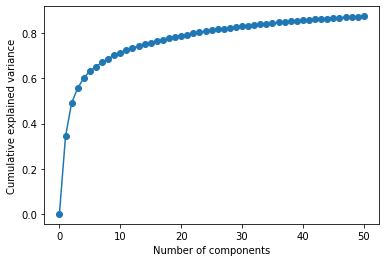

In [5]:
plt.plot(np.insert(pca.explained_variance_ratio_.cumsum(),0,0),marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [6]:
print(pca.explained_variance_ratio_.cumsum())

[0.3430633  0.49105203 0.55692321 0.60229875 0.63228666 0.65275144
 0.6713053  0.68744978 0.7027996  0.71459909 0.72563718 0.73518933
 0.74390688 0.75191367 0.75894645 0.76579792 0.77245627 0.77844684
 0.7841555  0.78950661 0.79475947 0.79960549 0.80427064 0.80868848
 0.81296554 0.81693465 0.82080257 0.82444982 0.82796023 0.83132771
 0.83445774 0.83744767 0.84030821 0.84304424 0.84563005 0.84811584
 0.85056981 0.85289526 0.8551713  0.85740261 0.85958179 0.86172626
 0.86371904 0.86559859 0.86739478 0.86911176 0.87082238 0.87247056
 0.8740866  0.87563764]


/home/mila/g/gauthies/.conda/envs/ultra/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
